In [1]:
import sys
import numpy as np
import phate
import graphtools as gt
import numpy as np
import pygsp
from src.mds import embed_MDS
import scprep
from scipy.spatial.distance import jensenshannon
from src.embedding import EmbJSD, EmbHeatGeo, EmbHeatPHATE, EmbCTD, EmbGraphMMD, EmbMarHeatGeo, CraneEmb, new_HeatGeo, DiffusionMap, ShortestPath
from src.sc_dataset import IPSC
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import umap
from dotenv import load_dotenv
import os
import seaborn as sns
from sklearn.manifold import TSNE

/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-12 18:42:40.713995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 18:42:42.750967: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-12 18:42:42.751070: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you

In [2]:
ds = IPSC(n_points=3000, random_state=42)
X_sub = ds.X
labels_sub = ds.labels
X_sub.shape

(3000, 33)

In [16]:
np.unique(labels_sub)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

In [6]:
knn = 5
tau = 10
methods = {
    "UMAP": umap.UMAP(n_neighbors=knn),
    "t-SNE": TSNE(),
    "PHATE": phate.PHATE(knn=knn, verbose=False),
    "Diffusion Maps": DiffusionMap(knn=knn, tau=tau),
    "ISOMAP": ShortestPath(knn=knn),
    "Heat-PHATE": EmbHeatPHATE(knn=knn, tau=tau, anisotropy=0, filter_method="mar"),
    "HeatGeo": new_HeatGeo(knn=knn, tau="auto",filter_method="mar"),
    "HeatGeo KNN": new_HeatGeo(knn=knn, tau="auto",filter_method="mar", graph_type="knn"),
    "HeatGeo umap": new_HeatGeo(knn=knn, tau="auto",filter_method="mar", graph_type="umap"),
    "HeatGeo Harnack": new_HeatGeo(knn=knn, tau="auto", filter_method="mar", harnack_regul=0.5),
    "HeatGeo Denoise": new_HeatGeo(knn=knn, tau="auto", denoising=True, n_ref=200, filter_method="mar"),
    "Heat Geo W": new_HeatGeo(knn=knn, tau="auto", filter_method="mar", scale_factor=2,mds_weights_args="inv"),
}

In [7]:
embedding = []
n = len(methods)
for name, emb_op in methods.items():
    print(name)
    emb = emb_op.fit_transform(X_sub)
    embedding.append(emb)

HeatGeo KNN
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. None
HeatGeo umap
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. None
HeatGeo Harnack


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. None
HeatGeo Denoise


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. None
Heat Geo W


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. None


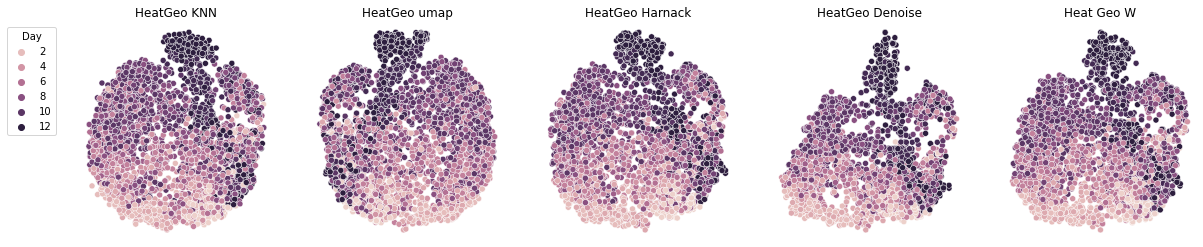

In [8]:
n = len(methods)
fig = plt.figure(figsize=(20, 4))
for i, (name,_) in enumerate(methods.items()):
    ax = fig.add_subplot(1, n, i+1)
    sns.scatterplot(x=embedding[i][:,0], y=embedding[i][:,1], hue=labels_sub, ax=ax)
    ax.set_title(name)
    ax.axis("off")
    ax.legend(title="Day", bbox_to_anchor=(-0.1, 1.0))
    if i>0:
        ax.get_legend().remove()
fig.savefig("eb_all_emb.png", bbox_inches="tight")

In [13]:
knn = 5
tau = 22
methods = {
    "HeatGeo KNN": new_HeatGeo(knn=knn, tau=tau,filter_method="mar", graph_type="knn"),
    "HeatGeo umap": new_HeatGeo(knn=knn, tau=tau,filter_method="mar", graph_type="umap"),
    "HeatGeo Harnack": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", harnack_regul=0.5),
    "HeatGeo Harnack 1.5": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", harnack_regul=1.5),
    "HeatGeo Denoise": new_HeatGeo(knn=knn, tau=tau, denoising=True, n_ref=200, filter_method="mar"),
    "Heat Geo W2": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", scale_factor=2,mds_weights_type="inv"),
    "Heat Geo W4": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", scale_factor=4,mds_weights_type="inv", mds_weights_args=2),
    "Heat Geo H4": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", scale_factor=4,mds_weights_type="heat_kernel"),
    "Heat Geo H4+H": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", scale_factor=2,mds_weights_type="heat_kernel", harnack_regul=0.5)
}

In [14]:
embedding = []
n = len(methods)
for name, emb_op in methods.items():
    print(name)
    emb = emb_op.fit_transform(X_sub)
    embedding.append(emb)

HeatGeo KNN
Using s_gd2 for MDS. None
HeatGeo umap
Using s_gd2 for MDS. None
HeatGeo Harnack


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. None
HeatGeo Harnack 1.5


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. None
HeatGeo Denoise


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. None
Heat Geo W2


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. None
Heat Geo W4


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. None
Heat Geo H4


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [2.02417450e-05 5.55309656e-05 1.63443882e-03 ... 4.99128370e-05
 1.43773387e-05 2.72684734e-05]
Heat Geo H4+H


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [2.02417450e-05 5.55309656e-05 1.63443882e-03 ... 4.99128370e-05
 1.43773387e-05 2.72684734e-05]


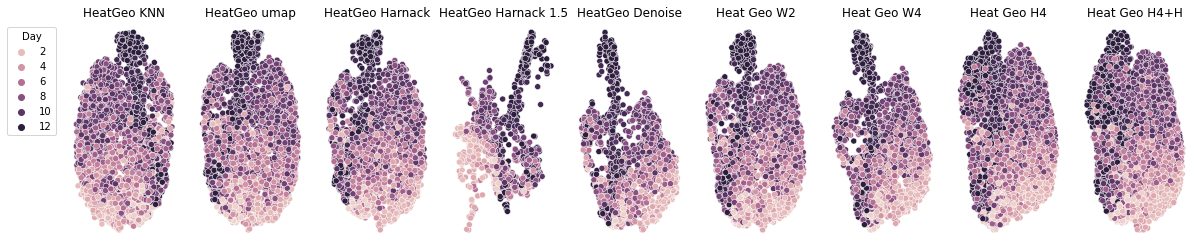

In [15]:
n = len(methods)
fig = plt.figure(figsize=(20, 4))
for i, (name,_) in enumerate(methods.items()):
    ax = fig.add_subplot(1, n, i+1)
    sns.scatterplot(x=embedding[i][:,0], y=embedding[i][:,1], hue=labels_sub, ax=ax)
    ax.set_title(name)
    ax.axis("off")
    ax.legend(title="Day", bbox_to_anchor=(-0.1, 1.0))
    if i>0:
        ax.get_legend().remove()
#fig.savefig("ipsc_.png", bbox_inches="tight")

In [16]:
knn = 5
tau = 22
methods = {f"Heat Geo {i} ": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", scale_factor=2,mds_weights_type="heat_kernel", harnack_regul=i) for i in [0.5,0.8,1.0,1.2,1.5,2.0]}

In [ ]:
embedding = []
n = len(methods)
for name, emb_op in methods.items():
    print(name)
    emb = emb_op.fit_transform(X_sub)
    embedding.append(emb)

IndexError: list index out of range

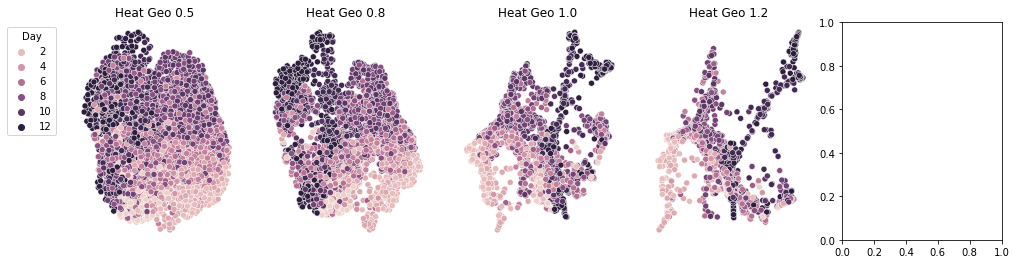

In [19]:
n = len(methods)
fig = plt.figure(figsize=(20, 4))
for i, (name,_) in enumerate(methods.items()):
    ax = fig.add_subplot(1, n, i+1)
    sns.scatterplot(x=embedding[i][:,0], y=embedding[i][:,1], hue=labels_sub, ax=ax)
    ax.set_title(name)
    ax.axis("off")
    ax.legend(title="Day", bbox_to_anchor=(-0.1, 1.0))
    if i>0:
        ax.get_legend().remove()

In [4]:
knn = 5
tau = 22
methods = {f"Heat Geo {i} ": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", scale_factor=i,mds_weights_type="heat_kernel", harnack_regul=0.2) for i in [0.5,0.8,1.0,1.2,1.5,2.0]}

In [5]:
embedding = []
n = len(methods)
for name, emb_op in methods.items():
    print(name)
    emb = emb_op.fit_transform(X_sub)
    embedding.append(emb)

Heat Geo 0.5 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [2.37421006e-04 9.74905186e-05 1.52832280e-04 ... 3.92082027e-05
 1.22235035e-04 8.50779439e-04]
Heat Geo 0.8 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [2.37421006e-04 9.74905186e-05 1.52832280e-04 ... 3.92082027e-05
 1.22235035e-04 8.50779439e-04]
Heat Geo 1.0 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [2.37421006e-04 9.74905186e-05 1.52832280e-04 ... 3.92082027e-05
 1.22235035e-04 8.50779439e-04]
Heat Geo 1.2 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [2.37421006e-04 9.74905186e-05 1.52832280e-04 ... 3.92082027e-05
 1.22235035e-04 8.50779439e-04]
Heat Geo 1.5 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [2.37421006e-04 9.74905186e-05 1.52832280e-04 ... 3.92082027e-05
 1.22235035e-04 8.50779439e-04]
Heat Geo 2.0 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [2.37421006e-04 9.74905186e-05 1.52832280e-04 ... 3.92082027e-05
 1.22235035e-04 8.50779439e-04]


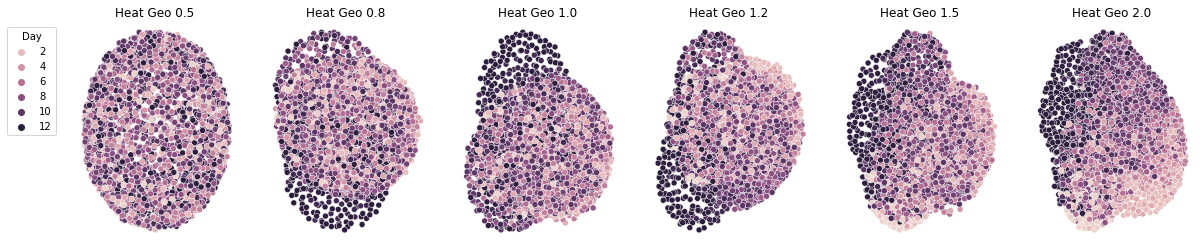

In [6]:
n = len(methods)
fig = plt.figure(figsize=(20, 4))
for i, (name,_) in enumerate(methods.items()):
    ax = fig.add_subplot(1, n, i+1)
    sns.scatterplot(x=embedding[i][:,0], y=embedding[i][:,1], hue=labels_sub, ax=ax)
    ax.set_title(name)
    ax.axis("off")
    ax.legend(title="Day", bbox_to_anchor=(-0.1, 1.0))
    if i>0:
        ax.get_legend().remove()

In [7]:
knn = 20
tau = 22
methods = {f"Heat Geo {i} ": new_HeatGeo(knn=knn, tau=tau, filter_method="mar", scale_factor=i,mds_weights_type="heat_kernel", harnack_regul=0.2) for i in [0.5,0.8,1.0,1.2,1.5,2.0]}

In [8]:
embedding = []
n = len(methods)
for name, emb_op in methods.items():
    print(name)
    emb = emb_op.fit_transform(X_sub)
    embedding.append(emb)

Heat Geo 0.5 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [0.00038074 0.00014932 0.00023745 ... 0.00010867 0.00023875 0.00076367]
Heat Geo 0.8 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [0.00038074 0.00014932 0.00023745 ... 0.00010867 0.00023875 0.00076367]
Heat Geo 1.0 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [0.00038074 0.00014932 0.00023745 ... 0.00010867 0.00023875 0.00076367]
Heat Geo 1.2 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [0.00038074 0.00014932 0.00023745 ... 0.00010867 0.00023875 0.00076367]
Heat Geo 1.5 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [0.00038074 0.00014932 0.00023745 ... 0.00010867 0.00023875 0.00076367]
Heat Geo 2.0 


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 33
  warnings.warn(


Using s_gd2 for MDS. [0.00038074 0.00014932 0.00023745 ... 0.00010867 0.00023875 0.00076367]


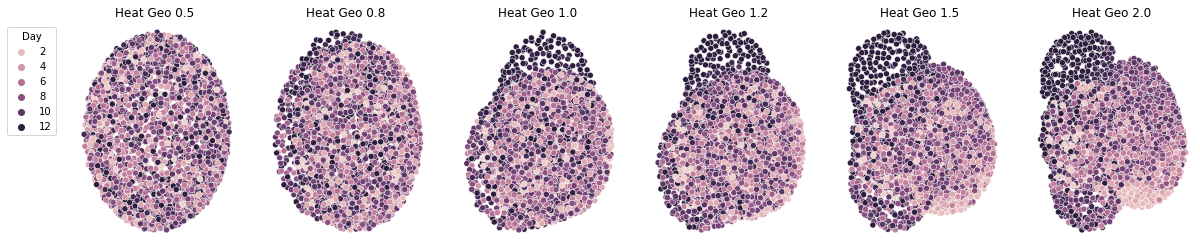

In [11]:
n = len(methods)
fig = plt.figure(figsize=(20, 4))
for i, (name,_) in enumerate(methods.items()):
    ax = fig.add_subplot(1, n, i+1)
    sns.scatterplot(x=embedding[i][:,0], y=embedding[i][:,1], hue=labels_sub, ax=ax)
    ax.set_title(name)
    ax.axis("off")
    ax.legend(title="Day", bbox_to_anchor=(-0.1, 1.0))
    if i>0:
        ax.get_legend().remove()